13.2 흉부 엑스선 기반 폐렴 진단 탐색적 데이터 분석

13.2.1 데이터 둘러보기

In [2]:
print("시작")

시작


In [3]:
# 데이터 경로
data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

In [4]:
from glob import glob

print(f'훈련 데이터 개수 : {len(glob(train_path + "*/*"))}')
print(f'검증 데이터 개수 : {len(glob(valid_path + "*/*"))}')
print(f'테스트 데이터 개수 : {len(glob(test_path + "*/*"))}')

훈련 데이터 개수 : 5216
검증 데이터 개수 : 16
테스트 데이터 개수 : 624


In [5]:
all_normal_imgs = []    # 모든 정상 이미지를 담을 리스트 초기화
all_pneumonia_imgs = [] # 모든 폐렴 이미지를 담을 리스트 초기화

for cat in ['train/', 'val/', 'test/']:
    data_cat_path = data_path + cat
    # 정상, 폐렴 이미지 경로
    normal_imgs = glob(data_cat_path + 'NORMAL/*')
    pneumonia_imgs = glob(data_cat_path + 'PNEUMONIA/*')
    # 정상, 폐렴 이미지 경로를 리스트에 추가
    all_normal_imgs.extend(normal_imgs)
    all_pneumonia_imgs.extend(pneumonia_imgs)

print(f'정상 흉부 이미지 개수 : {len(all_normal_imgs)}')
print(f'폐렴 흉부 이미지 개수 : {len(all_pneumonia_imgs)}')

정상 흉부 이미지 개수 : 1583
폐렴 흉부 이미지 개수 : 4273


13.2.2 데이터 시각화

타깃값 분포

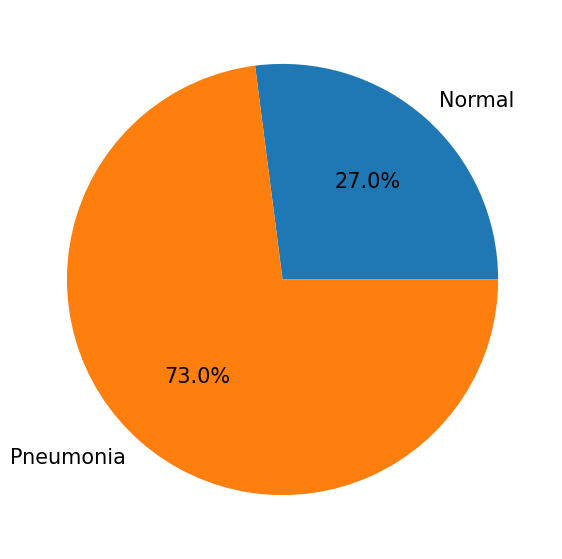

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Normal', 'Pneumonia'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(all_normal_imgs), len(all_pneumonia_imgs)], 
        labels=label, 
        autopct='%.1f%%');

이미지 출력

In [7]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3): 
    assert len(img_paths) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    mpl.rc('font', size=8)
    plt.figure(figsize=(15, 8)) 
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치

    # 이미지 출력
    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path) # 이미지 파일 읽기
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력

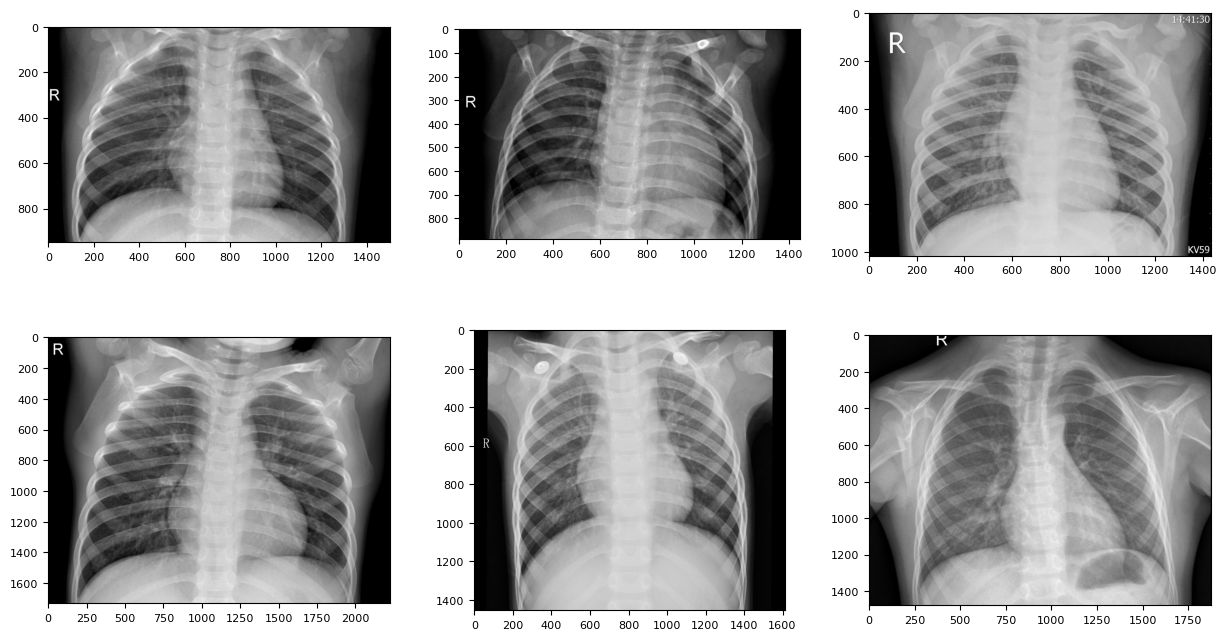

In [8]:
# 정상 엑스선 이미지 경로(마지막 6장)
num_of_imgs = 6
normal_img_paths = all_normal_imgs[-num_of_imgs:]

# 이미지 출력
show_image(normal_img_paths)

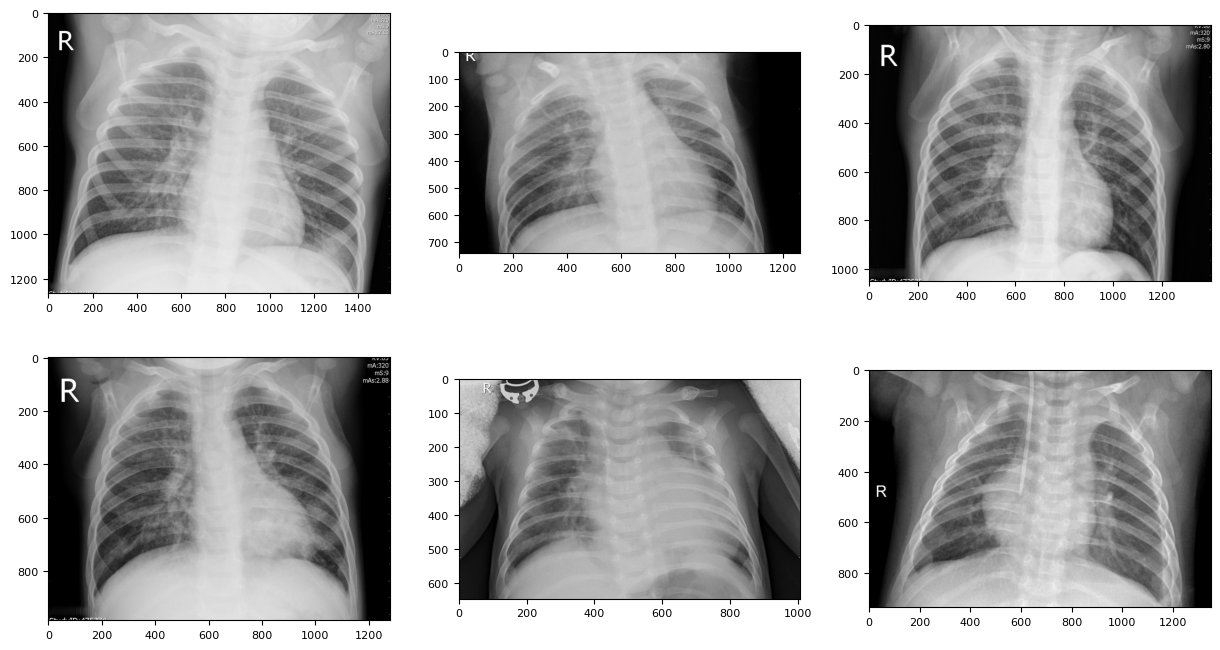

In [9]:
# 폐렴 엑스선 이미지 경로(마지막 6장)
pneumonia_img_paths = all_pneumonia_imgs[-num_of_imgs:]

# 이미지 출력
show_image(pneumonia_img_paths)

# 13.3 흉부 엑스선 기반 폐렴 진단 베이스라인 모델

13.3.1 시드 값 고정 및 GPU 장비 설정

시드값 고정

In [10]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

13.3.2 데이터 준비

In [12]:
# 데이터 경로
data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

데이터 증강을 위한 이미지 변환기 정의

In [13]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.Resize((250, 250)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

데이터셋 및 데이터 로더 생성

In [14]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root=valid_path, transform=transform_test) 

In [15]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 제너레이터 시드값 고정
g = torch.Generator()
g.manual_seed(0)

In [16]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

13.3.3 모델 생성

In [17]:
!pip install efficientnet-pytorch==0.7.1

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=4cea69e72b9a8e1810a51fb028f754e8b84662daefe979224a78481e96d3fc57
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
Successfully built efficientnet-pytorch


In [18]:
from efficientnet_pytorch import EfficientNet
# 모델 생성
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2) 
# 장비 할당
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [19]:
print('모델 파라미터 개수 :', sum(param.numel() for param in model.parameters()))

모델 파라미터 개수 : 4010110


13.3.4 모델 훈련 및 성능 검증

손실 함수와 옵티마이저 설정

In [20]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [21]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

훈련 및 성능 검증

In [22]:
# 모델 훈련
model_state_dict = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer)

에폭 [1/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.4127
	검증 데이터 손실값 : 1.2067
	정확도 : 0.5625 / 재현율 : 0.7500 / F1 점수 : 0.6316
	### 검증 데이터 손실값 감소 (inf --> 2.4134). 모델 저장
에폭 [2/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2539
	검증 데이터 손실값 : 0.9997
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
	### 검증 데이터 손실값 감소 (2.4134 --> 1.9994). 모델 저장
에폭 [3/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2485
	검증 데이터 손실값 : 1.1942
	정확도 : 0.5625 / 재현율 : 0.1250 / F1 점수 : 0.2222
에폭 [4/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2065
	검증 데이터 손실값 : 2.1693
	정확도 : 0.5000 / 재현율 : 0.0000 / F1 점수 : 0.0000
에폭 [5/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1923
	검증 데이터 손실값 : 1.2872
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [6/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1936
	검증 데이터 손실값 : 1.2021
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273
에폭 [7/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1687
	검증 데이터 손실값 : 2.0395
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [8/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1697
	검증 데이터 손실값 : 2.8859
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [9/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1467
	검증 데이터 손실값 : 0.5791
	정확도 : 0.6875 / 재현율 : 0.7500 / F1 점수 : 0.7059
	### 검증 데이터 손실값 감소 (1.9994 --> 1.1583). 모델 저장
에폭 [10/10] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1533
	검증 데이터 손실값 : 1.8763
	정확도 : 0.6250 / 재현율 : 1.0000 / F1 점수 : 0.7273


In [23]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

13.3.5 예측 및 평가 결과

In [24]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

예측

In [25]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [26]:
true_list, preds_list = predict(model=model, 
                                loader_test=loader_test, 
                                return_true=True)

평가 결과

In [27]:
print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8558
재현율 : 0.9205
F1 점수 : 0.8886


# 13.4 흉부 엑스선 기반 폐렴 진단 성능 개선

시드값 고정 및 GPU 장비 설정

In [28]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

데이터 준비

In [29]:
# 데이터 경로
data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path = data_path + 'test/'

데이터 증강을 위한 이미지 변환기 정의

In [30]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.Resize((250, 250)),      # 이미지 크기 조정 
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), 
                                               (0.229, 0.224, 0.225))])

데이터셋 및 데이터 로더 생성

In [31]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root=train_path, transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root=valid_path, transform=transform_test) 

In [32]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [33]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

13.4.1 모델 생성 및 훈련

In [34]:
!pip install efficientnet-pytorch==0.7.1

In [35]:
models_list =[] # 모델 저장용 리스트

In [36]:
from efficientnet_pytorch import EfficientNet

# 모델 생성
efficientnet_b1 = EfficientNet.from_pretrained('efficientnet-b1', num_classes=2) 
efficientnet_b2 = EfficientNet.from_pretrained('efficientnet-b2', num_classes=2)
efficientnet_b3 = EfficientNet.from_pretrained('efficientnet-b3', num_classes=2) 

# 장비 할당
efficientnet_b1 = efficientnet_b1.to(device)
efficientnet_b2 = efficientnet_b2.to(device)
efficientnet_b3 = efficientnet_b3.to(device)

# 리스트에 모델 저장
models_list.append(efficientnet_b1)
models_list.append(efficientnet_b2)
models_list.append(efficientnet_b3)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [37]:
for idx, model in enumerate(models_list):
    num_parmas = sum(param.numel() for param in model.parameters())
    print(f'모델{idx+1} 파라미터 개수 : {num_parmas}')

모델1 파라미터 개수 : 6515746
모델2 파라미터 개수 : 7703812
모델3 파라미터 개수 : 10699306


손실 함수, 옵티마이저, 스케줄러 설정

In [38]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [39]:
optimizer1 = torch.optim.AdamW(models_list[0].parameters(), lr=0.0006, weight_decay=0.001)
optimizer2 = torch.optim.AdamW(models_list[1].parameters(), lr=0.0006, weight_decay=0.001)
optimizer3 = torch.optim.AdamW(models_list[2].parameters(), lr=0.0006, weight_decay=0.001)

In [40]:
from transformers import get_cosine_schedule_with_warmup

epochs = 20 # 총 에폭

# 스케줄러
scheduler1 = get_cosine_schedule_with_warmup(optimizer1, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

scheduler2 = get_cosine_schedule_with_warmup(optimizer2, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

scheduler3 = get_cosine_schedule_with_warmup(optimizer3, 
                                    num_warmup_steps=len(loader_train)*3, 
                                    num_training_steps=len(loader_train)*epochs)

모델 훈련 및 성능 검증

In [41]:
from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer, 
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복 
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
            images = images.to(device)
            labels = labels.to(device)
            
            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item() 
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신 
                scheduler.step() 

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정 
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화
        
        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                # 예측값 및 실제값 
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy() 
                true = labels.cpu().numpy() 
    
                preds_list.extend(preds)
                true_list.extend(true)
                
        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
        if epoch_valid_loss <= valid_loss_min: 
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장 
            torch.save(model.state_dict(), save_file) 
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신 
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [42]:
# 첫 번째 모델 훈련
model_state_dict = train(model=models_list[0],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer1,
                         scheduler=scheduler1,
                         epochs=epochs)

# 첫 번째 모델에 최적 가중치 적용
models_list[0].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3128
	검증 데이터 손실값 : 0.3035
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
	### 검증 데이터 손실값 감소 (inf --> 0.6071). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1435
	검증 데이터 손실값 : 0.1543
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.6071 --> 0.3086). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1389
	검증 데이터 손실값 : 0.2073
	정확도 : 0.8125 / 재현율 : 0.6250 / F1 점수 : 0.7692
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1013
	검증 데이터 손실값 : 0.0354
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.3086 --> 0.0708). 모델 저장
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1006
	검증 데이터 손실값 : 0.6426
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0801
	검증 데이터 손실값 : 0.0339
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.0708 --> 0.0679). 모델 저장
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0701
	검증 데이터 손실값 : 0.9617
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0616
	검증 데이터 손실값 : 0.5762
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0511
	검증 데이터 손실값 : 0.3755
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0563
	검증 데이터 손실값 : 0.0410
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0429
	검증 데이터 손실값 : 0.0159
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.0679 --> 0.0318). 모델 저장
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0303
	검증 데이터 손실값 : 0.0951
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0322
	검증 데이터 손실값 : 0.0368
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0228
	검증 데이터 손실값 : 0.1053
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0199
	검증 데이터 손실값 : 0.3929
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0188
	검증 데이터 손실값 : 0.1702
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0111
	검증 데이터 손실값 : 0.1177
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0114
	검증 데이터 손실값 : 0.0831
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0100
	검증 데이터 손실값 : 0.1032
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0078
	검증 데이터 손실값 : 0.0847
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412


<All keys matched successfully>

In [ ]:
# 두 번째 모델 훈련
model_state_dict = train(model=models_list[1],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer2,
                         scheduler=scheduler2,
                         epochs=epochs)

# 두 번째 모델에 최적 가중치 적용
models_list[1].load_state_dict(model_state_dict)

에폭 [1/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3020
	검증 데이터 손실값 : 0.5883
	정확도 : 0.7500 / 재현율 : 1.0000 / F1 점수 : 0.8000
	### 검증 데이터 손실값 감소 (inf --> 1.1766). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1475
	검증 데이터 손실값 : 0.2094
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
	### 검증 데이터 손실값 감소 (1.1766 --> 0.4189). 모델 저장
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1192
	검증 데이터 손실값 : 0.3499
	정확도 : 0.8125 / 재현율 : 1.0000 / F1 점수 : 0.8421
에폭 [4/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1118
	검증 데이터 손실값 : 1.7949
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [5/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0837
	검증 데이터 손실값 : 0.6576
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [6/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0772
	검증 데이터 손실값 : 1.8771
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [7/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0703
	검증 데이터 손실값 : 0.3798
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [8/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0691
	검증 데이터 손실값 : 0.2584
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [9/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0592
	검증 데이터 손실값 : 0.0901
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.4189 --> 0.1801). 모델 저장
에폭 [10/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0442
	검증 데이터 손실값 : 1.1683
	정확도 : 0.5625 / 재현율 : 1.0000 / F1 점수 : 0.6957
에폭 [11/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0447
	검증 데이터 손실값 : 0.2045
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [12/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0390
	검증 데이터 손실값 : 0.4408
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [13/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0302
	검증 데이터 손실값 : 0.1544
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [14/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0289
	검증 데이터 손실값 : 0.0612
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1801 --> 0.1223). 모델 저장
에폭 [15/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0187
	검증 데이터 손실값 : 0.0192
	정확도 : 1.0000 / 재현율 : 1.0000 / F1 점수 : 1.0000
	### 검증 데이터 손실값 감소 (0.1223 --> 0.0384). 모델 저장
에폭 [16/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0196
	검증 데이터 손실값 : 0.2552
	정확도 : 0.8750 / 재현율 : 1.0000 / F1 점수 : 0.8889
에폭 [17/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0112
	검증 데이터 손실값 : 0.0918
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [18/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0080
	검증 데이터 손실값 : 0.0700
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [19/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0078
	검증 데이터 손실값 : 0.0735
	정확도 : 0.9375 / 재현율 : 1.0000 / F1 점수 : 0.9412
에폭 [20/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

In [ ]:
# 세 번째 모델 훈련
model_state_dict = train(model=models_list[2],
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer3,
                         scheduler=scheduler3,
                         epochs=epochs)

# 세 번째 모델에 최적 가중치 적용
models_list[2].load_state_dict(model_state_dict)

	훈련 데이터 손실값 : 0.2724
	검증 데이터 손실값 : 0.5293
	정확도 : 0.7500 / 재현율 : 0.8750 / F1 점수 : 0.7778
	### 검증 데이터 손실값 감소 (inf --> 1.0587). 모델 저장
에폭 [2/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1464
	검증 데이터 손실값 : 1.0409
	정확도 : 0.6875 / 재현율 : 1.0000 / F1 점수 : 0.7619
에폭 [3/20] 
-----------------------------


  0%|          | 0/652 [00:00<?, ?it/s]

13.4.2 예측 및 평가 결과

In [ ]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size, 
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

모델별 예측

In [ ]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값 

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [ ]:
true_list, preds_list1 = predict(model=models_list[0], 
                                 loader_test=loader_test, 
                                 return_true=True)

In [ ]:
preds_list2 = predict(model=models_list[1], 
                      loader_test=loader_test)

In [ ]:
preds_list3 = predict(model=models_list[2], 
                      loader_test=loader_test)

In [ ]:
print('#'*5, 'efficientnet-b1 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list1):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list1):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list1):.4f}')

In [ ]:
print('#'*5, 'efficientnet-b2 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list2):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list2):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list2):.4f}')

In [ ]:
print('#'*5, 'efficientnet-b3 모델 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list3):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list3):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list3):.4f}')

앙상블 예측

In [ ]:
ensemble_preds = []

for i in range(len(preds_list1)):
    pred_element = np.round((preds_list1[i] + preds_list2[i] + preds_list3[i])/3)
    ensemble_preds.append(pred_element)

평가 결과

In [ ]:
print('#'*5, '최종 앙상블 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, ensemble_preds):.4f}')
print(f'재현율 : {recall_score(true_list, ensemble_preds):.4f}')
print(f'F1 점수 : {f1_score(true_list, ensemble_preds):.4f}')

##### 최종 앙상블 결과 평가 점수 #####
정확도 : 0.8974
재현율 : 0.9923
F1 점수 : 0.9236